# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [5]:
# Display sample data
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


In [6]:
#remove the timestamp from the date

df.index = df.index.date

df.head()

,AGG,SPY
,close,close
2019-01-02,106.585,249.89
2019-01-03,107.020,244.46
2019-01-04,106.695,252.41
2019-01-07,106.470,254.40
2019-01-08,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [7]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()



#drop nulls

daily_returns = daily_returns.dropna().copy()


# Display sample data
daily_returns.head()

,AGG,SPY
,close,close
2019-01-03,0.004081,-0.021730
2019-01-04,-0.003037,0.032521
2019-01-07,-0.002109,0.007884
2019-01-08,-0.000470,0.008844
2019-01-09,0.000564,0.004130


In [8]:
#Calculate Value of Average Daily Returns
avg_daily_return_AGG = daily_returns.mean()["AGG"]["close"]
avg_daily_return_SPY = daily_returns.mean()["SPY"]["close"]
print(avg_daily_return_SPY)
print(avg_daily_return_AGG)

0.0010401250682146959
0.00021277231473764173


In [9]:
# Compute daily volatility
#calculate the standard deviation of daily returns

std_dev_daily_return_AGG = daily_returns.std()["AGG"]["close"]
std_dev_daily_return_SPY = daily_returns.std()["SPY"]["close"]
print(std_dev_daily_return_AGG)
print(std_dev_daily_return_SPY)


0.002089826211646555
0.007820053413439366


In [10]:
# Save the last day's closing price

AGG_last_price = df["AGG"]["close"][-1]
SPY_last_price = df["SPY"]["close"][-1]
print(SPY_last_price)

321.92


In [11]:
# Setup the Monte Carlo Parameters
num_simulations = 500
num_trading_days = 252 * 30
monte_carlo = pd.DataFrame()

In [12]:
# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next 30 trading year
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_AGG_prices = [AGG_last_price]
    simulated_SPY_prices = [SPY_last_price]
    
    # Simulate the returns for 252 days * 30 years
    for i in range(num_trading_days):
        
        # Append the simulated price to the list
        simulated_AGG_prices.append(simulated_AGG_prices[-1] * (1 + np.random.normal(avg_daily_return_AGG, std_dev_daily_return_AGG)))
        simulated_SPY_prices.append(simulated_SPY_prices[-1] * (1 + np.random.normal(avg_daily_return_SPY, std_dev_daily_return_SPY)))
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_AGG_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_SPY_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    #print(simulated_daily_returns)
    
    
    # Set the portfolio weights (40% AGG; 60% SPY)
    weights = [0.4, 0.6]
    
    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[f"Simulation{n+1}"] = (1 + portfolio_daily_returns.fillna(0)).cumprod()












In [13]:
# Check that the simulation ran successfully
# Print records from the DataFrame
portfolio_cumulative_returns.head()


,Simulation1,Simulation2,Simulation3,Simulation4,Simulation5,Simulation6,Simulation7,Simulation8,Simulation9,Simulation10,...,Simulation491,Simulation492,Simulation493,Simulation494,Simulation495,Simulation496,Simulation497,Simulation498,Simulation499,Simulation500
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000476,1.000536,0.998808,1.005394,1.011797,0.994452,0.997251,1.013277,1.000869,0.995376,...,1.002066,0.992709,1.001801,1.002671,0.996472,1.003160,1.001638,1.006800,0.998173,0.994765
2,1.008876,1.004699,1.003590,0.996711,1.009571,0.994247,0.994214,1.007199,1.000225,0.993036,...,1.005759,0.994517,1.003317,1.006181,0.997472,0.991774,1.002764,1.005408,0.996137,0.998871
3,1.008286,1.004228,1.003770,0.998232,1.007751,0.987669,0.998229,1.001361,1.000230,1.001279,...,1.006771,0.988444,1.004118,1.010565,0.993293,0.994454,1.008272,0.999144,0.998656,1.003328
4,1.013963,1.006575,1.008493,1.002636,1.013664,0.990972,1.003241,0.995491,1.002048,1.006036,...,1.004196,0.992123,1.004724,1.004423,0.994844,0.993782,1.005722,1.002248,0.996964,1.004095


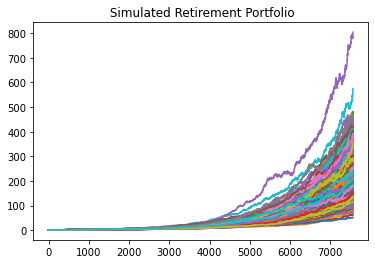

In [18]:
# Visualize the Simulation

# Use the `plot` function to plot `500` simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f" Simulated Retirement Portfolio"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)


In [15]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)

ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()


Simulation1    192.773859
Simulation2    171.964137
Simulation3    177.998514
Simulation4    138.466715
Simulation5    175.628015
Name: 7560, dtype: float64

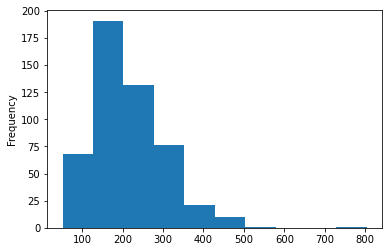

In [16]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind="hist", bins=10)

In [17]:
#Calculate the Probability Distribution of Ending Cumulative Return Ranges
# Use the `value_counts` function and the `len` function to calculate the probabilities of cumulative return ranges
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(126.818, 202.062]               0.382
(202.062, 277.305]               0.264
(277.305, 352.549]               0.152
(50.821000000000005, 126.818]    0.136
(352.549, 427.793]               0.042
(427.793, 503.037]               0.020
(728.768, 804.012]               0.002
(503.037, 578.28]                0.002
(653.524, 728.768]               0.000
(578.28, 653.524]                0.000
Name: 7560, dtype: float64

In [18]:
#Display the 90% confidence interval for the ending returns ??????
# Use the `quantile` function to calculate the 90% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    102.825606
0.95    379.341808
Name: 7560, dtype: float64

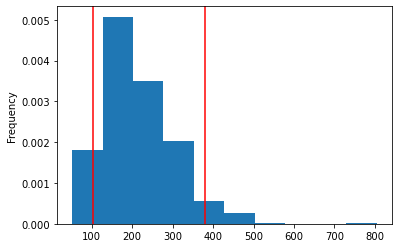

In [19]:
# Visualize the distribution of the ending returns??????
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 90% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')



---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [20]:
# Compute cumulative returns
expected_cum_returns = ending_cumulative_returns.quantile(q=[0.10, 0.5, 0.90])
expected_cum_returns



0.1    119.027485
0.5    199.083857
0.9    320.561549
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [41]:
# Set initial investment
initial_investment = 20000

# Compute expected portfolio return
expected_10th_percentile_return = initial_investment * expected_cum_returns.iloc[0]
expected_50th_percentile_return = initial_investment * expected_cum_returns.iloc[1]
expected_90th_percentile_return = initial_investment * expected_cum_returns.iloc[2]

# Print the results
print(f"The expected portfolio return at the 10th, 50th and 90th percentile of an initial investment of $20,000 "
      f" over the next 252 * 30 trading days will be"
      f"  ${expected_10th_percentile_return}, ${expected_50th_percentile_return}  and ${expected_90th_percentile_return}", )
 


The expected portfolio return at the 10th, 50th and 90th percentile of an initial investment of $20,000  over the next 252 * 30 trading days will be  $2380549.6980288406, $3981677.14343375  and $6411230.971271839


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [43]:
# Set Plaid's projected income
projected_income = 6085

Value_10th_percentile = expected_10th_percentile_return


# Calculate the 4% withdrawal for the ending return as retirement income
annual_withdrawal = Value_10th_percentile *.04

#print(annual_withdrawal)
 

# Determine if the retirement income meets or exceeds the current projected income
#Retirement income at end of first year at 1oth percentile

if annual_withdrawal >= projected_income :
    print(f'Retirement income meets or exceeds the current projected income')
else:
    print('no')


Retirement income meets or exceeds the current projected income


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [45]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
initial_investment = 20000*1.5

# Compute expected portfolio return
expected_10th_percentile_return = initial_investment * expected_cum_returns.iloc[0]

print(expected_10th_percentile_return)


# Calculate the 4% withdrawal for the ending return as retirement income
annual_withdrawal = expected_10th_percentile_return *.04



# Determine if the retirement income meets or exceeds the current projected income
#Retirement income at end of first year at 1oth percventile

if annual_withdrawal >= projected_income :
    print(f'The retirement income meets or exceeds the current projected income')
else:
    print('no')



3570824.547043261
The retirement income meets or exceeds the current projected income


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [26]:
# Compute projected returns

projected_returns = portfolio_cumulative_returns.quantile(q=[0.05, 0.5, 0.95],axis=1)
projected_returns


# Display sample data
projected_returns

,0,1,2,3,4,5,6,7,8,9,...,7551,7552,7553,7554,7555,7556,7557,7558,7559,7560
0.05,1.0,0.992691,0.990438,0.989383,0.988241,0.985508,0.985072,0.984571,0.984198,0.981626,...,103.250180,102.820669,102.959027,103.097859,103.417679,103.646181,103.048930,103.123992,102.888323,102.825606
0.50,1.0,1.000785,1.001287,1.002328,1.002972,1.003780,1.004727,1.005424,1.005591,1.007150,...,196.096555,196.527649,196.944371,196.754373,197.529554,198.046067,198.571688,198.582408,199.404147,199.083857
0.95,1.0,1.008573,1.013288,1.015727,1.018309,1.021726,1.023325,1.025437,1.027196,1.029502,...,377.831060,380.669946,382.172217,382.074639,381.629617,382.125745,381.218333,380.240758,379.940198,379.341808


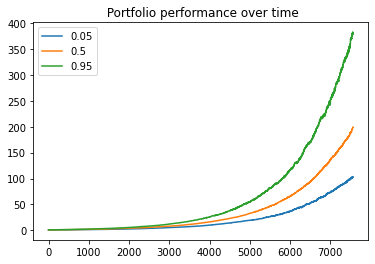

In [33]:
#Transpose dataframe and plot
plot_title = f" Portfolio performance over time"
projected_returns.T.plot(title=plot_title)

In [25]:
# Compute portfolio performance over time

# Plot projected performance over time
